              precision    recall  f1-score   support

           0       0.99      0.59      0.74       982
           1       0.03      0.61      0.05        18

    accuracy                           0.59      1000
   macro avg       0.51      0.60      0.39      1000
weighted avg       0.97      0.59      0.72      1000

ROC AUC: 0.6533152296899751


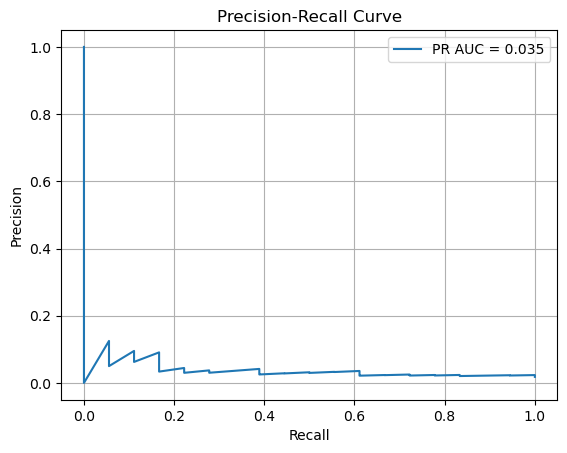

In [10]:
# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc
from sklearn.feature_selection import mutual_info_classif
from sklearn.utils import resample

# 2. Load Data
df = pd.read_csv("synth_rare_event_data.csv")
df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]
target_col = "rare_event"

# 3. Drop Missing & Encode
df = df.dropna(subset=[target_col])
X = df.drop(columns=[target_col])
y = df[target_col]

for col in X.select_dtypes(include='object').columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# 4. Train-Test Split BEFORE any scaling/feature selection
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

# 5. Scale Features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_raw), columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_raw), columns=X.columns)

# 6. Feature Selection (Top 15 from TRAINING ONLY)
mi = mutual_info_classif(X_train_scaled, y_train)
top_features = pd.Series(mi, index=X.columns).sort_values(ascending=False).head(15).index.tolist()

X_train_top = X_train_scaled[top_features]
X_test_top = X_test_scaled[top_features]

# 7. Manual Upsampling on TRAINING SET ONLY
train_df = pd.concat([X_train_top, y_train.reset_index(drop=True)], axis=1)
minority = train_df[train_df[target_col] == 1]
majority = train_df[train_df[target_col] == 0]

minority_upsampled = resample(
    minority,
    replace=True,
    n_samples=len(majority),
    random_state=42
)

upsampled_train = pd.concat([majority, minority_upsampled])
X_train_final = upsampled_train.drop(columns=[target_col])
y_train_final = upsampled_train[target_col]

# 8. Elastic Net Model
elastic_net = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    l1_ratio=0.5,
    C=1.0,
    max_iter=2000,
    tol=1e-4,
    class_weight='balanced',
    random_state=1
)
elastic_net.fit(X_train_final, y_train_final)

# 9. Evaluation
y_pred = elastic_net.predict(X_test_top)
y_prob = elastic_net.predict_proba(X_test_top)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

# 10. PR Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)

plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()